In [3]:

import random
import os
import os.path
import glob
import cv2
import imageio
import librosa
import scipy
import librosa.display
import IPython
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import Audio
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv1D, AveragePooling1D, MaxPooling1D
import tensorflow as tf
from keras import backend as K
import keras


In [4]:
Main_WAV_Path = Path("./speechdata")

In [5]:
Wav_Path = list(Main_WAV_Path.glob(r"**/*.wav"))

In [6]:
Wav_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Wav_Path))

In [7]:
Wav_Path_Series = pd.Series(Wav_Path,name="WAV").astype(str)
Wav_Labels_Series = pd.Series(Wav_Labels,name="EMOTION")

In [8]:
Main_Wav_Data = pd.concat([Wav_Path_Series,Wav_Labels_Series],axis=1)

In [9]:
print(Main_Wav_Data.head(-1))

                                          WAV    EMOTION
0     speechdata\OAF_angry\OAF_back_angry.wav  OAF_angry
1      speechdata\OAF_angry\OAF_bar_angry.wav  OAF_angry
2     speechdata\OAF_angry\OAF_base_angry.wav  OAF_angry
3     speechdata\OAF_angry\OAF_bath_angry.wav  OAF_angry
4     speechdata\OAF_angry\OAF_bean_angry.wav  OAF_angry
...                                       ...        ...
2794      speechdata\YAF_sad\YAF_wire_sad.wav    YAF_sad
2795     speechdata\YAF_sad\YAF_witch_sad.wav    YAF_sad
2796     speechdata\YAF_sad\YAF_yearn_sad.wav    YAF_sad
2797       speechdata\YAF_sad\YAF_yes_sad.wav    YAF_sad
2798     speechdata\YAF_sad\YAF_young_sad.wav    YAF_sad

[2799 rows x 2 columns]


In [10]:
print(Main_Wav_Data["EMOTION"].value_counts())

EMOTION
OAF_angry                 200
OAF_disgust               200
OAF_Fear                  200
OAF_happy                 200
OAF_neutral               200
OAF_Pleasant_surprise     200
OAF_Sad                   200
YAF_angry                 200
YAF_disgust               200
YAF_fear                  200
YAF_happy                 200
YAF_neutral               200
YAF_pleasant_surprised    200
YAF_sad                   200
Name: count, dtype: int64


In [11]:
Main_Wav_Data = Main_Wav_Data.sample(frac=1).reset_index(drop=True)

In [12]:
print(Main_Wav_Data.head(-1))

                                                    WAV                EMOTION
0                speechdata\OAF_Fear\OAF_cheek_fear.wav               OAF_Fear
1              speechdata\OAF_angry\OAF_mouse_angry.wav              OAF_angry
2                  speechdata\YAF_fear\YAF_lot_fear.wav               YAF_fear
3                 speechdata\YAF_sad\YAF_choice_sad.wav                YAF_sad
4           speechdata\YAF_neutral\YAF_sour_neutral.wav            YAF_neutral
...                                                 ...                    ...
2794   speechdata\OAF_Pleasant_surprise\OAF_soup_ps.wav  OAF_Pleasant_surprise
2795             speechdata\YAF_fear\YAF_chalk_fear.wav               YAF_fear
2796               speechdata\OAF_Sad\OAF_ditch_sad.wav                OAF_Sad
2797  speechdata\OAF_Pleasant_surprise\OAF_cheek_ps.wav  OAF_Pleasant_surprise
2798         speechdata\OAF_angry\OAF_thought_angry.wav              OAF_angry

[2799 rows x 2 columns]


In [13]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    
    return data

In [14]:
def stretch_process(data,rate=0.8):
    
    return librosa.effects.time_stretch(data,rate=0.8)

In [15]:
def shift_process(data):
    shift_range = int(np.random.uniform(low=-5,high=5) * 1000)
    
    return np.roll(data,shift_range)

In [16]:
def pitch_process(data,sampling_rate,pitch_factor=0.7):
    
    return librosa.effects.pitch_shift(data,sr=sampling_rate,n_steps=3)

In [22]:
def extract_process(data,sample_rate):
    
    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero))
    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_stft))
    
    mfcc_out = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_out))
    
    root_mean_out = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_mean_out))
    
    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_spectogram))
    
    return output_result

In [25]:
def export_process(path):
    
    data,sample_rate = librosa.load(path,duration=2.5,offset=0.6)
    
    output_1 = extract_process(data,sample_rate)
    result = np.array(output_1)
    
    noise_out = add_noise(data)
    output_2 = extract_process(noise_out,sample_rate)
    result = np.vstack((result,output_2))
    
    new_out = stretch_process(data)
    strectch_pitch = pitch_process(new_out,sample_rate)
    output_3 = extract_process(strectch_pitch,sample_rate)
    result = np.vstack((result,output_3))
    
    return result

In [26]:
x_Train, y_Train = [],[]

for path,emotion in zip(Main_Wav_Data.WAV,Main_Wav_Data.EMOTION):
    
    features = export_process(path)
    
    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

In [27]:
print(len(x_Train))
print(len(y_Train))
print(len(Main_Wav_Data.WAV))

8400
8400
2800


In [28]:
print(x_Train[0].shape)

(162,)


In [29]:
print(y_Train[0:5])

['OAF_Fear', 'OAF_Fear', 'OAF_Fear', 'OAF_angry', 'OAF_angry']


In [30]:
New_Features_Wav = pd.DataFrame(x_Train)
New_Features_Wav["EMOTIONS"] = y_Train

New_Features_Wav.to_csv("New_Wav_Set.csv",index=False)

In [31]:
New_Features_Wav.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,EMOTIONS
0,0.076508,0.425905,0.558566,0.627117,0.545209,0.460036,0.392065,0.318045,0.290940,0.370484,...,0.000295,0.000290,0.000281,0.000271,0.000135,0.000106,0.000114,0.000104,0.000009,OAF_Fear
1,0.175425,0.490825,0.676393,0.723008,0.630245,0.565593,0.475558,0.417674,0.398990,0.488653,...,0.000459,0.000458,0.000462,0.000457,0.000328,0.000271,0.000296,0.000307,0.000205,OAF_Fear
2,0.098185,0.446758,0.352680,0.381252,0.373236,0.489176,0.597108,0.485667,0.428310,0.366864,...,0.000216,0.000143,0.000109,0.000064,0.000101,0.000098,0.000046,0.000030,0.000002,OAF_Fear
3,0.080545,0.637043,0.402595,0.354304,0.439552,0.527001,0.354342,0.337670,0.444431,0.447895,...,0.000122,0.000083,0.000207,0.000333,0.000209,0.000153,0.000108,0.000109,0.000008,OAF_angry
4,0.141326,0.720279,0.557174,0.444992,0.481960,0.578639,0.423770,0.371503,0.473347,0.500792,...,0.000376,0.000372,0.000468,0.000585,0.000449,0.000390,0.000341,0.000339,0.000265,OAF_angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,0.108655,0.673711,0.554280,0.548467,0.536860,0.456404,0.388764,0.365634,0.364626,0.430392,...,0.000177,0.000192,0.000164,0.000187,0.000098,0.000054,0.000052,0.000040,0.000004,OAF_angry
8395,0.124109,0.683944,0.562215,0.569900,0.559503,0.494660,0.409075,0.390500,0.394605,0.435828,...,0.000194,0.000206,0.000180,0.000202,0.000111,0.000074,0.000069,0.000057,0.000020,OAF_angry
8396,0.130670,0.499005,0.549556,0.588037,0.637856,0.477407,0.550121,0.462721,0.376556,0.342688,...,0.000170,0.000218,0.000235,0.000184,0.000082,0.000059,0.000037,0.000024,0.000003,OAF_angry
8397,0.051916,0.466071,0.432077,0.467894,0.528333,0.610952,0.668488,0.511801,0.435700,0.399467,...,0.000180,0.000207,0.000152,0.000121,0.000111,0.000094,0.000075,0.000037,0.000002,OAF_Pleasant_surprise


In [32]:
print(New_Features_Wav["EMOTIONS"].value_counts())

EMOTIONS
OAF_Fear                  600
OAF_angry                 600
YAF_fear                  600
YAF_sad                   600
YAF_neutral               600
YAF_angry                 600
OAF_Sad                   600
YAF_disgust               600
YAF_pleasant_surprised    600
YAF_happy                 600
OAF_neutral               600
OAF_Pleasant_surprise     600
OAF_happy                 600
OAF_disgust               600
Name: count, dtype: int64


In [33]:
encoder_label = OneHotEncoder()

In [34]:
scaler_data = StandardScaler()

In [35]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["EMOTIONS"].values

In [36]:
print(X.shape)
print(Y.shape)

(8400, 162)
(8400,)


In [37]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [38]:
print(Y.shape)

(8400, 14)


In [39]:
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,train_size=0.9,random_state=42,shuffle=True)

In [40]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(7560, 162)
(7560, 14)
(840, 162)
(840, 14)


In [41]:
xTrain = scaler_data.fit_transform(xTrain)
xTest = scaler_data.transform(xTest)

In [42]:
print(xTrain.shape)
print(xTest.shape)

(7560, 162)
(840, 162)


In [43]:
xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [44]:
print(xTrain.shape)
print(xTest.shape)

(7560, 162, 1)
(840, 162, 1)


In [45]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xTrain.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=14, activation='softmax'))

In [46]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [48]:
Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=10, validation_data=(xTest, yTest), callbacks=[early_stop])

Epoch 1/10


119/119 [==============================] - 21s 126ms/step - loss: 1.8932 - accuracy: 0.3616 - val_loss: 0.8860 - val_accuracy: 0.7381
Epoch 2/10
119/119 [==============================] - 15s 125ms/step - loss: 0.8935 - accuracy: 0.6962 - val_loss: 0.3923 - val_accuracy: 0.8643
Epoch 3/10
119/119 [==============================] - 14s 117ms/step - loss: 0.5974 - accuracy: 0.7939 - val_loss: 0.2932 - val_accuracy: 0.9131
Epoch 4/10
119/119 [==============================] - 14s 120ms/step - loss: 0.4601 - accuracy: 0.8462 - val_loss: 0.2704 - val_accuracy: 0.9190
Epoch 5/10
119/119 [==============================] - 14s 117ms/step - loss: 0.3524 - accuracy: 0.8762 - val_loss: 0.1949 - val_accuracy: 0.9369
Epoch 6/10
119/119 [==============================] - 14s 119ms/step - loss: 0.3328 - accuracy: 0.8882 - val_loss: 0.1203 - val_accuracy: 0.9607
Epoch 7/10
119/119 [==============================] - 14s 120ms/step - loss: 0.2496 - accuracy: 0.9161 - val_loss: 0.1220 - val_

In [49]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


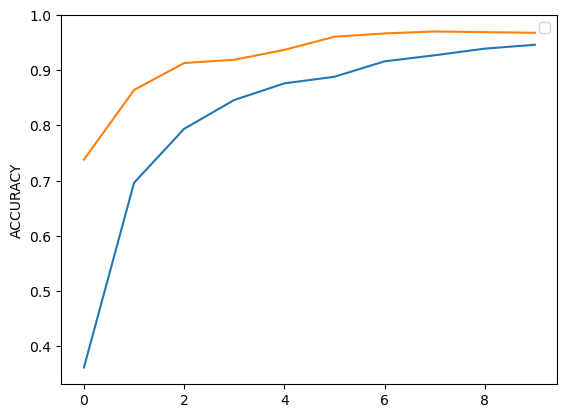

In [50]:
plt.plot(Conv1D_Model.history["accuracy"])
plt.plot(Conv1D_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

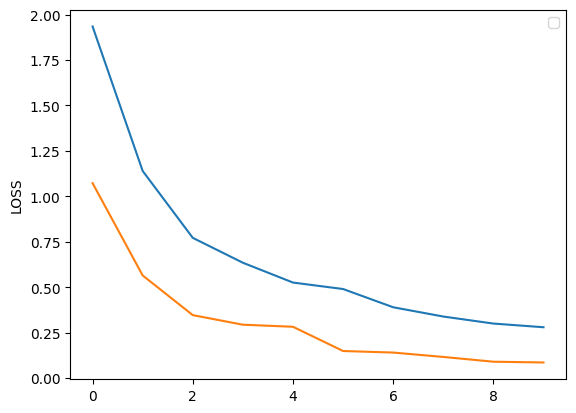

In [101]:
plt.plot(Conv1D_Model.history["loss"])
plt.plot(Conv1D_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.show()

In [51]:
prediction_test = Model.predict(xTest)
y_prediction = encoder_label.inverse_transform(prediction_test)

yTest = encoder_label.inverse_transform(yTest)

27/27 [==============================] - 1s 17ms/step


In [52]:
print(y_prediction[0:10])

[['YAF_pleasant_surprised']
 ['OAF_happy']
 ['YAF_sad']
 ['YAF_pleasant_surprised']
 ['YAF_sad']
 ['YAF_neutral']
 ['OAF_Pleasant_surprise']
 ['OAF_Pleasant_surprise']
 ['YAF_angry']
 ['OAF_disgust']]


In [53]:
print(yTest[0:10])

[['YAF_pleasant_surprised']
 ['OAF_happy']
 ['YAF_sad']
 ['YAF_pleasant_surprised']
 ['YAF_sad']
 ['YAF_neutral']
 ['OAF_Pleasant_surprise']
 ['OAF_happy']
 ['YAF_angry']
 ['OAF_Pleasant_surprise']]
